# P6 Classifiez automatiquement des biens de consommation : Traitement de texte
## Importation des librairies et des données

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [2]:
raw_data = pd.read_csv('text_1050.csv')

reindexed_data = raw_data['description']
reindexed_data.index = raw_data['image']

## Isolation des features importantes et prétraitement du texte

In [3]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    
    vectorized_description = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_description, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_description.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    most_frequent_words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (most_frequent_words, word_values[0,:n_top_words].tolist()[0])

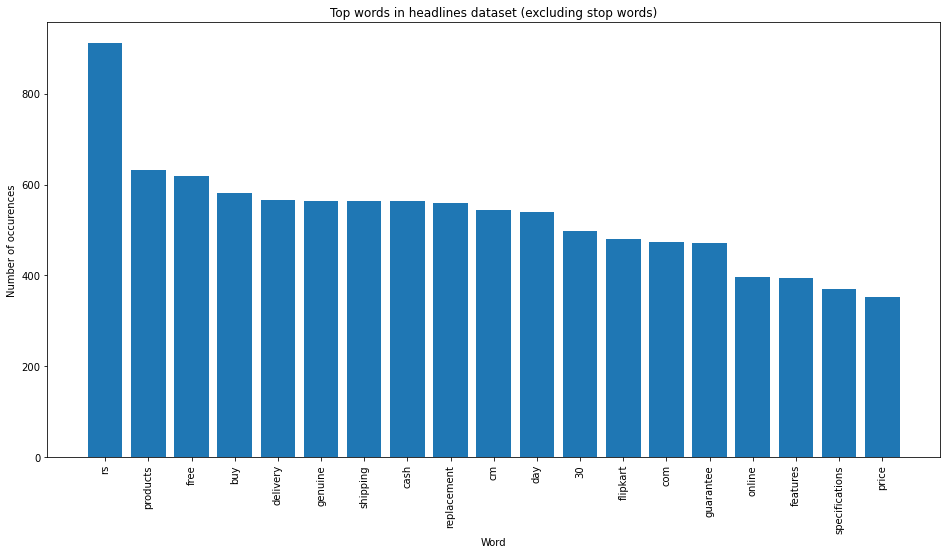

In [4]:
count_vectorizer = CountVectorizer(stop_words='english')
most_frequent_words, word_values = get_top_n_words(n_top_words=19,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(most_frequent_words)), word_values);
ax.set_xticks(range(len(most_frequent_words)));
ax.set_xticklabels(most_frequent_words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### Suppression des mots les plus fréquents, stopwords & punctuation

In [5]:
most_frequent_words

['rs',
 'products',
 'free',
 'buy',
 'delivery',
 'genuine',
 'shipping',
 'cash',
 'replacement',
 'cm',
 'day',
 '30',
 'flipkart',
 'com',
 'guarantee',
 'online',
 'features',
 'specifications',
 'price']

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import nltk
from string import punctuation

stop_words = set(stopwords.words('english'))
print(type(stop_words))

mots_a_supprimer = set.union(set(most_frequent_words),stop_words,punctuation)
print(type(mots_a_supprimer))

<class 'set'>
<class 'set'>


In [7]:
print(mots_a_supprimer)

{'am', 'how', 'through', 'price', 'i', "mightn't", '?', 'nor', '=', '(', 'did', 'there', '@', 'them', 'ain', '}', 'when', 'each', 'an', 'over', "shan't", 'up', 'they', '/', 'just', 'on', 'has', "haven't", 'own', "needn't", 'whom', 'needn', 'be', '~', 'against', ',', 'here', "aren't", "didn't", 'y', 'replacement', "weren't", 'will', 'is', 'from', 'and', 'ours', '#', 'products', 'while', 'he', "wasn't", "mustn't", "that'll", 'shan', '*', ']', 'but', 'in', 'him', 'into', '_', 'themselves', 'few', 'wasn', 'hasn', 'myself', 'until', "hadn't", 'can', 'you', 'with', '!', 'had', 'her', 'weren', 'too', 'com', 'shouldn', '`', 'this', "shouldn't", "you'll", "you'd", 'are', 's', 'what', 'online', 'only', 've', '%', '{', 'should', "won't", 'not', "you're", "hasn't", 'was', 'won', 'other', 'haven', '$', 'rs', 'does', 'once', 'hadn', 'above', 'have', 'm', 'doing', 'under', 'ourselves', 'we', 'its', "you've", 'at', '-', '|', 'so', 'guarantee', '[', 'most', ';', 'yourselves', '<', 'more', "she's", 'fea

In [8]:
import re
for i in range (reindexed_data.shape[0]) :
  reindexed_data[i] = re.sub('[^A-Za-z]', ' ', reindexed_data[i]).lower()

<ipython-input-8-5aa9548263a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reindexed_data[i] = re.sub('[^A-Za-z]', ' ', reindexed_data[i]).lower()


In [9]:
reindexed_data[0]

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain      cm in height  pack of    price  rs      this curtain enhances the look of the interiors this curtain is made from      high quality polyester fabric it features an eyelet style stitch with metal ring it makes the room environment romantic and loving this curtain is ant  wrinkle and anti shrinkage and have elegant apparance give your home a bright and modernistic appeal with these designs  the surreal attention is sure to steal hearts  these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening  you create the most special moments of joyous beauty given by the soothing prints  bring home the elegant curtain that softly filters light in your room so that you

In [10]:
def Tokenizer(str_input):
    words = word_tokenize(str_input)
    return words

In [11]:
tokenized_data = reindexed_data.copy()

for i in range(reindexed_data.shape[0]):
    tokenized_data[i]=Tokenizer(reindexed_data[i])
    
print(tokenized_data[0])

['key', 'features', 'of', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'in', 'height', 'pack', 'of', 'price', 'rs', 'this', 'curtain', 'enhances', 'the', 'look', 'of', 'the', 'interiors', 'this', 'curtain', 'is', 'made', 'from', 'high', 'quality', 'polyester', 'fabric', 'it', 'features', 'an', 'eyelet', 'style', 'stitch', 'with', 'metal', 'ring', 'it', 'makes', 'the', 'room', 'environment', 'romantic', 'and', 'loving', 'this', 'curtain', 'is', 'ant', 'wrinkle', 'and', 'anti', 'shrinkage', 'and', 'have', 'elegant', 'apparance', 'give', 'your', 'home', 'a', 'bright', 'and', 'modernistic', 'appeal', 'with', 'these', 'designs', 'the', 'surreal', 'attention', 'is', 'sure', 'to', 'steal', 'hearts', 'these', 'contemporary', 'eyelet', 'and', 'valance', 'curtains', 'slide', 'smoothly', 'so', 'when', 'you', 'draw', 'them', 'apart', 'first', 'thing', 'in', 

In [12]:
tokenized_data = tokenized_data.apply(lambda x: ' '.join([word for word in x if word not in (mots_a_supprimer)]))

In [13]:
tokenized_data[0]

'key elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack curtain enhances look interiors curtain made high quality polyester fabric eyelet style stitch metal ring makes room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal designs surreal attention sure steal hearts contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlight elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id duster color multicolor dimensions length box number contents sales package pack sales package cu

### Extraction de la racine

In [14]:
def Stemmer(str_input):
    str_input = str_input.lower()
    words = word_tokenize(str_input)
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    #stem the words
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [15]:
stemmed_tokenized_data = tokenized_data.copy()

for i in range(tokenized_data.shape[0]):
    stemmed_tokenized_data[i]=Stemmer(stemmed_tokenized_data[i])
    
print(stemmed_tokenized_data[0])

['key', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'curtain', 'enhanc', 'look', 'interior', 'curtain', 'made', 'high', 'qualiti', 'polyest', 'fabric', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room', 'environ', 'romant', 'love', 'curtain', 'ant', 'wrinkl', 'anti', 'shrinkag', 'eleg', 'appar', 'give', 'home', 'bright', 'modernist', 'appeal', 'design', 'surreal', 'attent', 'sure', 'steal', 'heart', 'contemporari', 'eyelet', 'valanc', 'curtain', 'slide', 'smoothli', 'draw', 'apart', 'first', 'thing', 'morn', 'welcom', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morn', 'whole', 'world', 'draw', 'close', 'even', 'creat', 'special', 'moment', 'joyou', 'beauti', 'given', 'sooth', 'print', 'bring', 'home', 'eleg', 'curtain', 'softli', 'filter', 'light', 'room', 'get', 'right', 'amount', 'sunlight', 'eleg', 'polyest', 'multicolor', 'ab

In [16]:
stemmed_tokenized_data = stemmed_tokenized_data.apply(lambda x: ' '.join([word for word in x]))
print(stemmed_tokenized_data[0])

key eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain height pack curtain enhanc look interior curtain made high qualiti polyest fabric eyelet style stitch metal ring make room environ romant love curtain ant wrinkl anti shrinkag eleg appar give home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount sunlight eleg polyest multicolor abstract eyelet door curtain height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model id duster color multicolor dimens length box number content sale packag pack sale packag curtain bodi design materi polyest


In [17]:
tagged_headlines = [TextBlob(stemmed_tokenized_data[i]).pos_tags for i in range(stemmed_tokenized_data.shape[0])]
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per Description: ', np.mean(word_counts).round(0))

Total number of words:  47331
Mean number of words per Description:  45.0


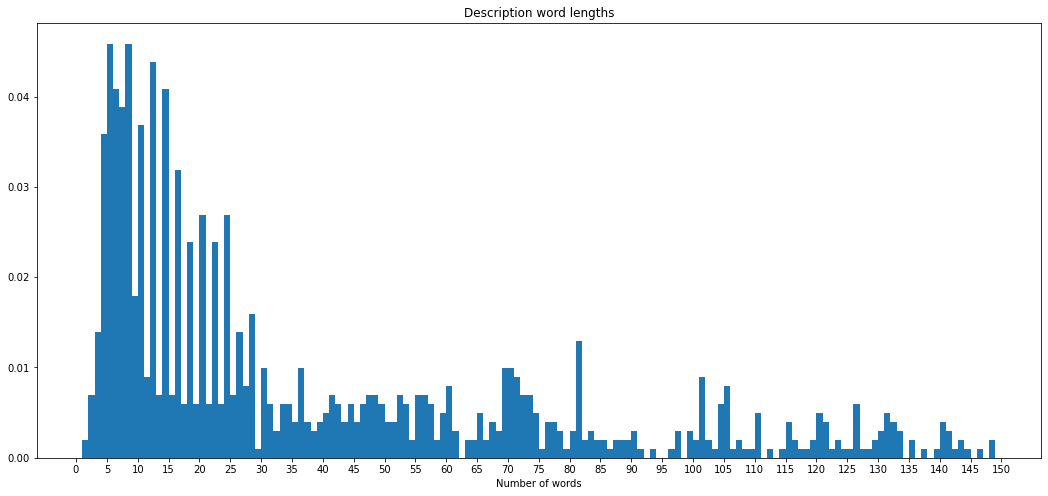

In [18]:
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,150), density=True);
ax.set_title('Description word lengths');
ax.set_xticks(range(0,155,5));
ax.set_xlabel('Number of words');
plt.show()

### Vectorisation des Descriptions

In [19]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=50000)
small_text_sample = stemmed_tokenized_data.sample(n=1050).values

print('Description before vectorization: {}'.format(small_text_sample[0]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Description after vectorization: \n{}'.format(small_document_term_matrix[0]))

Description before vectorization: maspar cotton set towel one beach towel red percent cotton soft absorb machin washabl percent cotton soft absorb machin washabl
Description after vectorization: 
  (0, 2131)	1
  (0, 787)	3
  (0, 3122)	1
  (0, 3626)	2
  (0, 297)	1
  (0, 2868)	1
  (0, 2552)	2
  (0, 3268)	2
  (0, 12)	2
  (0, 2080)	2
  (0, 3852)	2


## LDA Topic Modelling

In [20]:
n_topics = 7

In [21]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [22]:
def get_keys(topic_matrix):

    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):

    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [23]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [24]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
   
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [25]:
top_n_words_lda = get_top_n_words(15, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  watch analog men inch cover print color great india skin discount warranti women laptop packag
Topic 2:  babi girl fabric cotton adapt dress boy gener print ideal sleev type light power warranti
Topic 3:  showpiec towel price bath best cotton lowest skin india pack soft soap spf oudh absorb
Topic 4:  batteri showpiec pack box usb model wall sticker design color materi number laptop packag type
Topic 5:  mug coffe ceram perfect gift design love ml tea pizza qualiti enjoy materi bring prithish
Topic 6:  set product design combo beauti ceram gift craft make materi mug rockmantra size perfect come
Topic 7:  price best kadhai combo showpiec frame crystal set kit cream photo idli massag energi vitamin


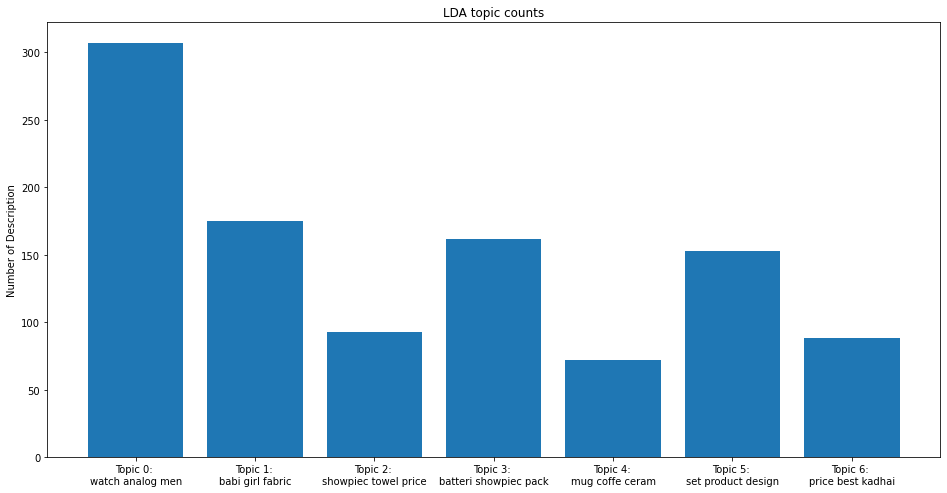

In [26]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of Description');

In [27]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.001s...
[t-SNE] Computed neighbors for 1050 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.013139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.004284
[t-SNE] KL divergence after 2000 iterations: 0.259505


In [28]:
def get_mean_topic_vectors(keys, two_dim_vectors):
   
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [29]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [30]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

Cette LDA nous a permis de regrouper par descriptions similaires nos produits.
Cette méthode reste néanmoins peu précise, c'est pour cela que nous allons réaliser une classification en prenant comme cible la catégorie de chaque produit. 
## Classification de texte

Nous préparons tout d'abord nos catégories.

In [31]:
categories = raw_data['product_category_tree']
categories.index = raw_data.image

for i in range (categories.shape[0]) :
  categories[i] = re.sub('[^A-Za-z]', ' ', categories[i]).lower()

<ipython-input-31-94eb2171bb66>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories[i] = re.sub('[^A-Za-z]', ' ', categories[i]).lower()


In [32]:
print(categories)

image
55b85ea15a1536d46b7190ad6fff8ce7.jpg      home furnishing    curtains   accessories   ...
7b72c92c2f6c40268628ec5f14c6d590.jpg      baby care    baby bath   skin    baby bath t...
64d5d4a258243731dc7bbb1eef49ad74.jpg      baby care    baby bath   skin    baby bath t...
d4684dcdc759dd9cdf41504698d737d8.jpg      home furnishing    bed linen    bedsheets   ...
6325b6870c54cd47be6ebfbffa620ec7.jpg      home furnishing    bed linen    bedsheets   ...
                                                              ...                        
958f54f4c46b53c8a0a9b8167d9140bc.jpg      baby care    baby   kids gifts    stickers  ...
fd6cbcc22efb6b761bd564c28928483c.jpg      baby care    baby   kids gifts    stickers  ...
5912e037d12774bb73a2048f35a00009.jpg      baby care    baby   kids gifts    stickers  ...
c3edc504d1b4f0ba6224fa53a43a7ad6.jpg      baby care    baby   kids gifts    stickers  ...
f2f027ad6a6df617c9f125173da71e44.jpg      baby care    baby   kids gifts    stickers  ...
Name

In [33]:
tokenized_cat = categories.copy()

for i in range(tokenized_cat.shape[0]):
    tokenized_cat[i]=Tokenizer(tokenized_cat[i])
    
print(tokenized_cat[0])

['home', 'furnishing', 'curtains', 'accessories', 'curtains', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'do']


In [34]:
tokenized_cat = tokenized_cat.apply(lambda x: ' '.join([word for word in x if word not in (mots_a_supprimer)]))

In [35]:
tokenized_cat[0]

'home furnishing curtains accessories curtains elegance polyester multicolor abstract eyelet'

In [36]:
stemmed_tokenized_cat = tokenized_cat.copy()

for i in range(tokenized_cat.shape[0]):
    stemmed_tokenized_cat[i]=Stemmer(stemmed_tokenized_cat[i])
    
print(stemmed_tokenized_cat[0])

['home', 'furnish', 'curtain', 'accessori', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet']


In [37]:
Y = pd.DataFrame({'cat_name' : stemmed_tokenized_cat,
                    'image_name' : stemmed_tokenized_cat.index})
Y = Y.reset_index(drop=True)

Y.head()

,cat_name,image_name
0,"[home, furnish, curtain, accessori, curtain, e...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,"[babi, care, babi, bath, skin, babi, bath, tow...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,"[babi, care, babi, bath, skin, babi, bath, tow...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,"[home, furnish, bed, linen, bedsheet, santosh,...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,"[home, furnish, bed, linen, bedsheet, jaipur, ...",6325b6870c54cd47be6ebfbffa620ec7.jpg


In [38]:
Y['cat']=Y.cat_name

for i in range(Y.cat_name.shape[0]) :
    Y['cat'][i]=Y.cat_name[i][:2]

Y.cat = Y.cat.apply(lambda x: ' '.join([word for word in x]))

Y.head()

,cat_name,image_name,cat
0,"[home, furnish, curtain, accessori, curtain, e...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnish
1,"[babi, care, babi, bath, skin, babi, bath, tow...",7b72c92c2f6c40268628ec5f14c6d590.jpg,babi care
2,"[babi, care, babi, bath, skin, babi, bath, tow...",64d5d4a258243731dc7bbb1eef49ad74.jpg,babi care
3,"[home, furnish, bed, linen, bedsheet, santosh,...",d4684dcdc759dd9cdf41504698d737d8.jpg,home furnish
4,"[home, furnish, bed, linen, bedsheet, jaipur, ...",6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnish


In [54]:
Y.cat.value_counts()

home furnish      150
kitchen dine      150
babi care         150
home decor        150
beauti person     150
watch wrist       149
comput laptop      89
comput network     49
comput comput       6
comput tablet       3
comput storag       2
watch clock         1
comput softwar      1
Name: cat, dtype: int64

In [55]:
Y['label']=Y.cat

for i in range(Y.cat.shape[0]):
    if Y.cat[i]=='home furnish':
        Y.label[i]=0
    elif Y.cat[i]=='beauti person':
        Y.label[i]=1
    elif Y.cat[i]=='kitchen dine':
        Y.label[i]=2
    elif Y.cat[i]=='home decor':
        Y.label[i]=3
    elif Y.cat[i]=='babi care':
        Y.label[i]=4
    else :
        if Y.cat[i].__contains__('watch')==True:
            Y.label[i]=5
        else :
            Y.label[i]=6
            
Y.label.value_counts()

6    150
5    150
4    150
3    150
2    150
1    150
0    150
Name: label, dtype: int64

In [57]:
Y.drop('cat_name', axis=1).to_csv('images_categories.csv')

In [42]:
for i in range(7):
    print('Label number {}: '.format(i) , '{}'.format(Y.loc[Y.label==i, 'cat'][:1].values))


Label number 0:  ['home furnish']
Label number 1:  ['beauti person']
Label number 2:  ['kitchen dine']
Label number 3:  ['home decor']
Label number 4:  ['babi care']
Label number 5:  ['watch wrist']
Label number 6:  ['comput network']


Suite à cette analyse des catégories nous trouvons ici 7 principales thématiques : 
- 0. Home Furnishing
- 1. Beauty and Personal Care 
- 2. Kichen and Dining
- 3. Home Decoration
- 4. Baby Care
- 5. Watches
- 6. Computers

Il est temps maintenant de réaliser notre classification. Nous allons donc vectorialiser nos descriptions, les séparers et Train & Test puis réaliser une Classification RandomForest.

In [43]:
stemmed_tokenized_data.values

array(['key eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain height pack curtain enhanc look interior curtain made high qualiti polyest fabric eyelet style stitch metal ring make room environ romant love curtain ant wrinkl anti shrinkag eleg appar give home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount sunlight eleg polyest multicolor abstract eyelet door curtain height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model id duster color multicolor dimens length box number content sale packag pack sale packag curtain bodi design materi polyest',
       'sathiya cotton bath towel bath towel red 

In [44]:
count_vectorizer=CountVectorizer(stop_words='english',max_features=500)

vectorized_description = count_vectorizer.fit_transform(stemmed_tokenized_data.values)

print(vectorized_description[1])

  (0, 129)	2
  (0, 184)	1
  (0, 49)	1
  (0, 460)	1
  (0, 288)	2
  (0, 221)	1
  (0, 89)	1
  (0, 136)	1
  (0, 255)	1
  (0, 47)	1
  (0, 306)	1
  (0, 104)	1
  (0, 392)	2
  (0, 321)	2
  (0, 275)	1
  (0, 108)	3
  (0, 32)	6
  (0, 456)	6
  (0, 374)	2
  (0, 498)	2
  (0, 42)	2
  (0, 270)	1
  (0, 478)	1
  (0, 496)	1
  (0, 396)	1
  (0, 198)	1
  (0, 222)	1
  (0, 280)	1
  (0, 490)	1
  (0, 48)	1
  (0, 187)	1
  (0, 413)	1
  (0, 226)	2
  (0, 489)	1


In [45]:
X, y = vectorized_description, Y.label.values
y=y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [46]:
X_train_array = X_train.toarray()

In [47]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train_array, y_train)

RandomForestClassifier()

In [48]:
y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.9301587301587302


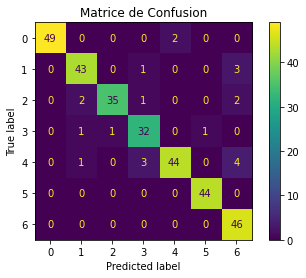

In [49]:
#print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(model, X_test, y_test)
plt.title('Matrice de Confusion')
plt.show()

Sans même optimisations du modèle, nous obtenons une Accuracy de plus de 92%. Nous observons donc que la classification du texte des descriptions d'image est faisable et que nous avons tous les élément nécessaires à disposition. 

Nous allons passer désormais au traitement des images afin de voir s'il est possible d'en faire de même.